<a href="https://colab.research.google.com/github/beatlesatani/coding_september/blob/main/sentiment_analysis_with_pretrained_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook contains codes that do sentiment_analysis using transformer library which is like words-embedding, pre-trained classification model. However, I tried to make classification model without  pre-trained model. As a result, my machine power was not enough to make iteration. So, I switched to use pre-trained model from transformer.

### the codes in this notebook is based on https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/09.deploy-BERT-with-FastAPI.ipynb

In [ ]:
!pip install tensorflow_text

In [ ]:

 pip install "tf-models-official==2.13.*"

In [ ]:
!pip install transformers

In [ ]:
import os
import shutil
import re
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from torch import nn, optim
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from collections import defaultdict

In [ ]:
#setup the dataset
test = 'https://raw.githubusercontent.com/beatlesatani/coding_september/main/test.csv'
train = "https://raw.githubusercontent.com/beatlesatani/coding_september/main/train.csv"
test = pd.read_csv(test,encoding='unicode_escape')
train = pd.read_csv(train,encoding='unicode_escape')
# remove unusuful columns
test = test.iloc[:,1:3]
train = train.iloc[:, [1,3]]
#check the insull values of train dataframe
train.isnull().sum()
#only one text is missing, so drop that low that incluse null cell
train = train.dropna()
#re-check null values
train.isnull().sum()

text         0
sentiment    0
dtype: int64

In [ ]:
#check the insull values of train dataframe
test.isnull().sum()

text         1281
sentiment    1281
dtype: int64

In [ ]:
#afeter checking original csv file, all raws after 3533 is null
test = test.dropna()
#re-check null values
test.isnull().sum()

text         0
sentiment    0
dtype: int64

In [ ]:
#check the label imbalance
train['sentiment'].value_counts(normalize=True)

neutral     0.404549
positive    0.312300
negative    0.283151
Name: sentiment, dtype: float64

In [ ]:
test['sentiment'].value_counts(normalize=True)

neutral     0.404641
positive    0.312111
negative    0.283248
Name: sentiment, dtype: float64

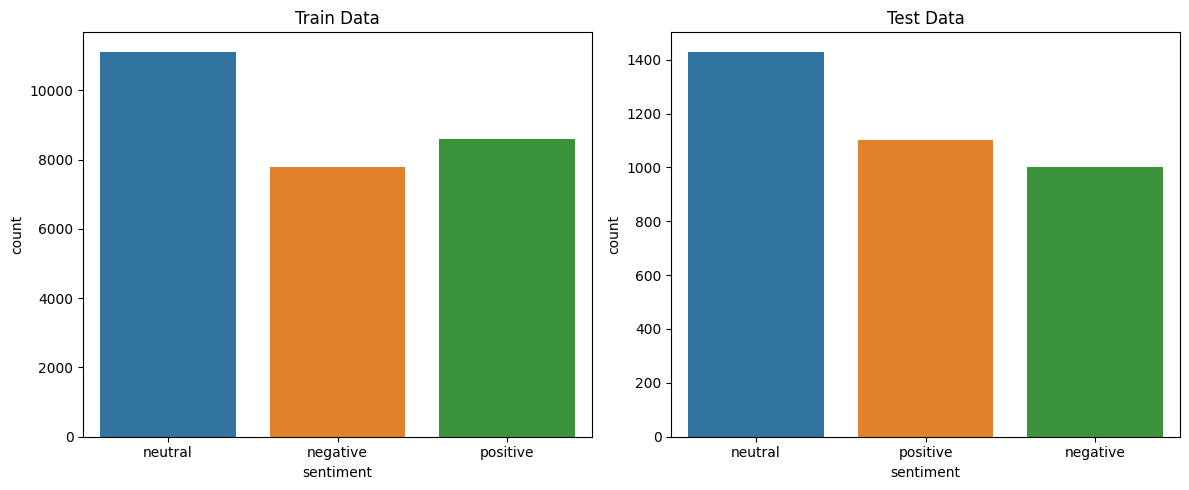

In [ ]:
#graph
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x='sentiment', data=train, ax=axes[0],saturation = 0.75)
axes[0].set_title('Train Data')

# Plot the countplot for 'sentiment' in the 'test' DataFrame
sns.countplot(x='sentiment', data=test, ax=axes[1])
axes[1].set_title('Test Data')

# Adjust layout for better visibility
plt.tight_layout()

# Show the plots
plt.show()

## we can conclude the labels are not inbalanced

## convert each sentiment into numerical value
neagtive → -1
neutral → 0
postive → 1

In [ ]:
'''
#before working to the model, convert labels into numerical number
train['label'] = train['sentiment'].apply(lambda x: -1 if x== 'negative' else(0 if x == 'neutral' else 1))
train = train.drop('sentiment',axis = 1)
test['label'] = test['sentiment'].apply(lambda x: -1 if x== 'negative' else(0 if x == 'neutral' else 1))
test = test.drop('sentiment',axis = 1)
'''
# Convert labels to integers: negative -> 0, neutral -> 1, positive -> 2
train['label'] = train['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})
test['label'] = test['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})


In [ ]:
#train['label'].value_counts(normalize=True) # got same ratio before converting

In [ ]:

'''
split the dataset
X_train = train['text']
y_train = train['label']
X_test = test['text']
y_test = test['label']
'''

"\nsplit the dataset\nX_train = train['text']\ny_train = train['label']\nX_test = test['text']\ny_test = test['label']\n"

In [ ]:
'''
#convert label to one-hot-coding
y_train = pd.get_dummies(y_train, columns = ['label'])
y_test = pd.get_dummies(y_test, columns = ['label'])
'''

"\n#convert label to one-hot-coding\ny_train = pd.get_dummies(y_train, columns = ['label'])\ny_test = pd.get_dummies(y_test, columns = ['label'])\n"

## From here I will use transformer library from Hugging-face.
The transformer library of Hugging Face contains PyTorch implementation of state-of-the-art NLP models including BERT (from Google), GPT (from OpenAI) ... and pre-trained model weights.

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:

tokens = tokenizer.tokenize(train.iloc[0,0])
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {train.iloc[0,0]}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence:  I`d have responded, if I were going
   Tokens: ['I', '`', 'd', 'have', 'responded', ',', 'if', 'I', 'were', 'going']
Token IDs: [146, 169, 173, 1138, 5133, 117, 1191, 146, 1127, 1280]


In [ ]:
train

,text,sentiment,label
0,"I`d have responded, if I were going",neutral,1
1,Sooo SAD I will miss you here in San Diego!!!,negative,0
2,my boss is bullying me...,negative,0
3,what interview! leave me alone,negative,0
4,"Sons of ****, why couldn`t they put them on t...",negative,0
...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,0
27477,I`ve wondered about rake to. The client has ...,negative,0
27478,Yay good for both of you. Enjoy the break - y...,positive,2
27479,But it was worth it ****.,positive,2


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id


('[CLS]', 101)

In [ ]:

tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
text_to_encode = train.iloc[25][0]
print(text_to_encode)

the free fillin` app on my ipod is fun, im addicted


In [ ]:
encoding = tokenizer.encode_plus(
  text_to_encode,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding="max_length",
  #truncation = True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)


encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  1103,  1714,  5475,  1394,   169, 12647,  1113,  1139,   178,
         5674,  1181,  1110,  4106,   117, 13280,  5194, 27825,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [ ]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'the',
 'free',
 'fill',
 '##in',
 '`',
 'app',
 'on',
 'my',
 'i',
 '##po',
 '##d',
 'is',
 'fun',
 ',',
 'im',
 'add',
 '##icted',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
# to find the longest length, I gonna concat train,test
df = pd.concat([train,test])

In [ ]:
token_lens = []

for txt in df["text"]:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<ipython-input-89-4dbe9bd8b56e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


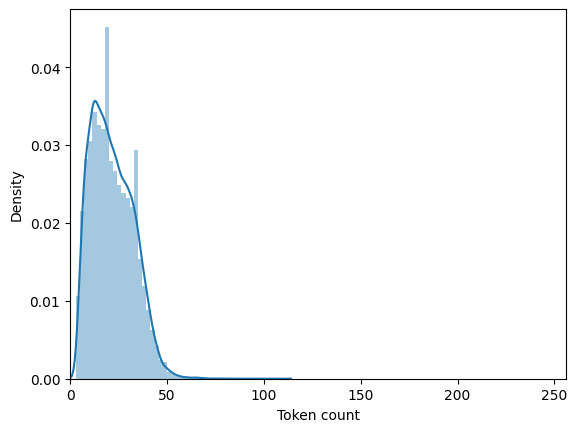

In [ ]:

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');


In [ ]:
# I chose 75
MAX_LEN = 75
BATCH_SIZE = 16

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, text, label, tokenizer, max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'label': torch.tensor(label, dtype=torch.long)
    }





In [ ]:
#ここはtrain,testのままでいけると判断  df_valのみを作る
train, df_value = train_test_split(train, test_size=0.1, random_state=101)

In [ ]:
train.shape,test.shape,df_value.shape

((24732, 3), (3534, 3), (2748, 3))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    text=df.text.to_numpy(),
    label=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )



In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_value, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:

data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

dict_keys(['text', 'input_ids', 'attention_mask', 'label'])

In [ ]:

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

torch.Size([16, 75])
torch.Size([16, 75])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [ ]:
#last_hidden_state.shape

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
#pooled_output.shape

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(bert_model.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[1]  # Take the pooled_output from BERT
        output = self.drop(pooled_output)
        return self.out(output)


In [ ]:
classifier_model = SentimentClassifier(len(label_mapping))

In [ ]:
# Loss function and optimizer for the classifier
classifier_loss_fn = nn.CrossEntropyLoss()
classifier_optimizer = optim.AdamW(classifier_model.parameters(), lr=2e-5)

In [ ]:
# Training loop for the classifier
def train_classifier_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    n_examples
):
    model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]

        classifier_optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)

        train_loss = loss_fn(outputs, labels)

        train_loss.backward()
        optimizer.step()

        correct_predictions += torch.sum(preds == labels)
        losses.append(train_loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
class_names = ['negative', 'neutral', 'positive']
model = SentimentClassifier(len(class_names))

In [ ]:
# Evaluation loop for the classifier
def eval_classifier_model(model, data_loader, loss_fn, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            labels = batch["label"]

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)

            val_loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(val_loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Number of training epochs for the classifier
CLASSIFIER_EPOCHS = 5

In [130]:
# Training loop for the classifier
for epoch in range(CLASSIFIER_EPOCHS):
    print(f'Classifier Epoch {epoch + 1}/{CLASSIFIER_EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_classifier_epoch(
        classifier_model,
        train_data_loader,
        classifier_loss_fn,
        classifier_optimizer,
        len(train_data)
    )


Classifier Epoch 1/5
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

KeyboardInterrupt: ignored

In [ ]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [ ]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    scheduler,
    n_examples
):
    model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"]
        attention_mask = d["attention_mask"]
        label = d["label"]

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, label)

        correct_predictions += torch.sum(preds == label)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, n_examples):
    model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"]
            attention_mask = d["attention_mask"]
            labels = d["label"]  # Assuming labels are already integers

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            loss = loss_fn(outputs, labels)

            _, preds = torch.max(outputs, dim=1)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        scheduler,
        len(train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        len(df_value)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    # Get predictions on the validation data
    val_predictions = []
    model.eval()
    with torch.no_grad():
        for batch in val_data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)
            val_predictions.extend(predictions.cpu().numpy())

    print("Val Labels:", [label.item() for label in df_value["label"]])
    print("Val Predictions:", val_predictions)

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc
